In [1]:
import mlflow
import feast
from src.load_data import load_data_from_feature_store

C:\Users\User\PycharmProjects\Data Science Testing\.venv\Lib\site-packages\feast\feature_view.py:48: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity '__dummy'.
  DUMMY_ENTITY = Entity(


In [2]:
from google.cloud import bigquery

# Initialize a BigQuery client
client = bigquery.Client()

# Define your project, dataset, and table
project_id = "carbon-relic-439014-t0"
dataset_id = "chicago_taxi"
table_id = "data"

# Construct the fully qualified table name
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Load data into a Pandas DataFrame
query = f"SELECT * FROM `{table_ref}`"
df = client.query(query).to_dataframe()

# Display first few rows
print(df.head())


                                 unique_key  \
0  014a3c1524cab7a2f5acdea53834e7e2dcbc5bc9   
1  00027ae211d7fd552013fe498637cf2799f37499   
2  00040a617bef514a1b26076a674dafef3966378e   
3  00040a617bef514a1b26076a674dafef3966378e   
4  00012902ec577e1a25815a527b4204782daa98c8   

                                             taxi_id  \
0  bd30d866401ef22dcebc3ae81dc4d45f3d8de4dc4426fd...   
1  a325b14b280bbfdff06d740fb9ef083a12af4310f36402...   
2  aba7b7acc0bc874f790aa6859ab9566f67d3b3dc992062...   
3  aba7b7acc0bc874f790aa6859ab9566f67d3b3dc992062...   
4  4628ef9dfa973bdfe877c5aa9d9738f9dc1204e54f2f1a...   

       trip_start_timestamp        trip_end_timestamp  trip_seconds  \
0 2024-01-09 18:30:00+00:00 2024-01-10 06:15:00+00:00         42300   
1 2024-01-29 07:45:00+00:00 2024-01-29 08:15:00+00:00          1320   
2 2024-01-17 08:00:00+00:00 2024-01-17 08:45:00+00:00          2525   
3 2024-01-17 08:00:00+00:00 2024-01-17 08:45:00+00:00          2525   
4 2024-01-09 15:15:00+00:

In [4]:
df.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,999754.0,1.000045e+06,280072.0,191295.0,863426.0,507575.0,998020.000000,998020.000000,998020.000000,998020.000000,998020.000000,863550.000000,863550.000000,508343.000000,508343.000000
mean,1387.83293,8.755826e+00,17031602186.405195,17031436079.490803,45.887469,37.179853,28.539335,3.339428,0.156052,5.807143,38.000770,41.897919,-87.735384,41.837724,-87.648478
std,2017.28274,9.527195e+00,384482.247558,343736.348697,26.587596,20.30186,28.892677,5.494543,16.659274,25.547747,51.032926,0.081492,0.129667,0.074895,0.067546
min,0.0,0.000000e+00,17031010201.0,17031010202.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,41.650222,-87.913625,41.660136,-87.913625
25%,600.0,1.090000e+00,17031281900.0,17031081600.0,28.0,28.0,10.000000,0.000000,0.000000,0.000000,13.250000,41.870415,-87.903040,41.779583,-87.657233
50%,1212.0,7.720000e+00,17031839100.0,17031320100.0,42.0,33.0,27.750000,0.000000,0.000000,0.000000,30.000000,41.899156,-87.663518,41.874005,-87.631864
75%,1851.0,1.354000e+01,17031980000.0,17031839100.0,76.0,51.0,39.250000,5.000000,0.000000,5.000000,53.200000,41.979071,-87.626211,41.890922,-87.617860
max,86340.0,1.132360e+03,17031980100.0,17031980100.0,77.0,77.0,8550.680000,400.000000,6666.660000,6666.660000,9043.820000,42.016046,-87.534903,42.016046,-87.534903


In [5]:
df.isna().sum()

unique_key                     0
taxi_id                        0
trip_start_timestamp           0
trip_end_timestamp            73
trip_seconds                 296
trip_miles                     5
pickup_census_tract       719978
dropoff_census_tract      808755
pickup_community_area     136624
dropoff_community_area    492475
fare                        2030
tips                        2030
tolls                       2030
extras                      2030
trip_total                  2030
payment_type                   0
company                        0
pickup_latitude           136500
pickup_longitude          136500
pickup_location           136500
dropoff_latitude          491707
dropoff_longitude         491707
dropoff_location          491707
timestamp                      0
dtype: int64

In [51]:
df.drop(columns=["pickup_census_tract", "dropoff_census_tract", "pickup_community_area", "dropoff_community_area", "pickup_latitude", "pickup_longitude", "pickup_location", "dropoff_latitude", "dropoff_longitude", "dropoff_location"], inplace=True)

In [52]:
df.shape

(1000020, 14)

<Axes: xlabel='trip_miles', ylabel='trip_seconds'>

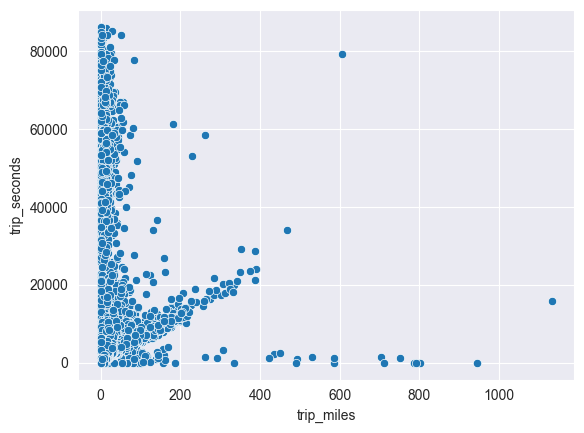

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="trip_miles",y="trip_seconds")

In [30]:
df = df[df["trip_miles"] < 600]

In [31]:
df.shape

(1000004, 14)

In [ ]:
sns.scatterplot(data=df, x="trip_miles",y="trip_seconds")

In [33]:
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,company,timestamp
0,00026d0f3a120b38f67ede4936fdff72c9f80dab,f71223a469d78a2f65a090adc9d4fb5ae08dfc6694c650...,2024-01-04 17:00:00+00:00,2024-01-04 17:15:00+00:00,1341,5.44,11.65,2.0,0.0,0.0,13.65,Mobile,Chicago Independents,2025-02-08 19:33:13.666354+00:00
1,0003099fde70eac4923f761ef28d8411660bc609,9fcefcaa49ef3229c8e75e02120101fbd92b329677ceea...,2024-01-09 08:00:00+00:00,2024-01-09 08:15:00+00:00,368,0.45,5.50,4.0,0.0,0.0,10.00,Credit Card,Globe Taxi,2025-02-08 19:33:13.666354+00:00
2,0003b82b1faf4afe41b09ca74785f77cc7b41160,e2ee1c538fd08e5d895c4d2a62d821b601034db0cebece...,2024-01-05 21:30:00+00:00,2024-01-05 21:45:00+00:00,248,0.20,4.50,0.0,0.0,0.0,4.50,Prcard,Taxicab Insurance Agency Llc,2025-02-08 19:33:13.666354+00:00
3,00012d162a043f81c15d07cd9117032f2b96cf11,31760477ea8a53823f828158e65e02b57866ed72ce86b7...,2024-01-20 16:00:00+00:00,2024-01-20 16:45:00+00:00,2503,16.48,42.00,0.0,0.0,4.0,46.00,Cash,Taxicab Insurance Agency Llc,2025-02-03 19:45:26.321450+00:00
4,70d00a6977fe18c25be6895a668fc4fbbeabe419,feb9a71dcd524378d243372a5a61e3d50553304b130979...,2023-12-12 18:15:00+00:00,2023-12-12 18:30:00+00:00,837,1.33,9.50,0.0,0.0,0.0,9.50,Cash,Flash Cab,2025-02-02 19:35:16.886464+00:00


In [53]:
df["daytime"] = df["trip_start_timestamp"].dt.hour
df['day_type'] = df['trip_start_timestamp'].dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'weekday')
df['month'] = df['trip_start_timestamp'].dt.month
df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
df['day_of_month'] = df['trip_start_timestamp'].dt.day

In [35]:
df.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,company,timestamp,daytime,day_type,month,day_of_week,day_of_month
0,00026d0f3a120b38f67ede4936fdff72c9f80dab,f71223a469d78a2f65a090adc9d4fb5ae08dfc6694c650...,2024-01-04 17:00:00+00:00,2024-01-04 17:15:00+00:00,1341,5.44,11.65,2.0,0.0,0.0,13.65,Mobile,Chicago Independents,2025-02-08 19:33:13.666354+00:00,17,weekday,1,3,4
1,0003099fde70eac4923f761ef28d8411660bc609,9fcefcaa49ef3229c8e75e02120101fbd92b329677ceea...,2024-01-09 08:00:00+00:00,2024-01-09 08:15:00+00:00,368,0.45,5.50,4.0,0.0,0.0,10.00,Credit Card,Globe Taxi,2025-02-08 19:33:13.666354+00:00,8,weekday,1,1,9
2,0003b82b1faf4afe41b09ca74785f77cc7b41160,e2ee1c538fd08e5d895c4d2a62d821b601034db0cebece...,2024-01-05 21:30:00+00:00,2024-01-05 21:45:00+00:00,248,0.20,4.50,0.0,0.0,0.0,4.50,Prcard,Taxicab Insurance Agency Llc,2025-02-08 19:33:13.666354+00:00,21,weekday,1,4,5
3,00012d162a043f81c15d07cd9117032f2b96cf11,31760477ea8a53823f828158e65e02b57866ed72ce86b7...,2024-01-20 16:00:00+00:00,2024-01-20 16:45:00+00:00,2503,16.48,42.00,0.0,0.0,4.0,46.00,Cash,Taxicab Insurance Agency Llc,2025-02-03 19:45:26.321450+00:00,16,weekend,1,5,20
4,70d00a6977fe18c25be6895a668fc4fbbeabe419,feb9a71dcd524378d243372a5a61e3d50553304b130979...,2023-12-12 18:15:00+00:00,2023-12-12 18:30:00+00:00,837,1.33,9.50,0.0,0.0,0.0,9.50,Cash,Flash Cab,2025-02-02 19:35:16.886464+00:00,18,weekday,12,1,12


In [56]:
df["avg_tips_per_taxi"] = df.groupby("taxi_id")["tips"].transform("mean")

In [57]:
df_clean = df.drop(columns=["unique_key", "taxi_id", "trip_start_timestamp", "trip_end_timestamp", "timestamp", "fare", "tips"])

In [62]:
df_clean.dropna(inplace=True)

In [59]:
df_clean.head()

,trip_seconds,trip_miles,tolls,extras,trip_total,payment_type,company,daytime,day_type,month,day_of_week,day_of_month,avg_tips_per_taxi
0,1341,5.44,0.0,0.0,13.65,Mobile,Chicago Independents,17,weekday,1,3,4,3.581327
1,368,0.45,0.0,0.0,10.00,Credit Card,Globe Taxi,8,weekday,1,1,9,3.671023
2,248,0.20,0.0,0.0,4.50,Prcard,Taxicab Insurance Agency Llc,21,weekday,1,4,5,2.578197
3,2503,16.48,0.0,4.0,46.00,Cash,Taxicab Insurance Agency Llc,16,weekend,1,5,20,6.227757
4,837,1.33,0.0,0.0,9.50,Cash,Flash Cab,18,weekday,12,1,12,2.959325


In [65]:
df_clean.shape

(997734, 13)

In [73]:
# Remove outliers using IQR
def remove_outliers(df, cols):
    for col in cols:
        if df[col].dtype not in ["int64", "float64"]:
            continue  # Skip non-numeric columns

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


In [74]:
df_clean = remove_outliers(df,cols=["trip_miles","trip_seconds","trip_total"])

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor

# Define categorical and numerical columns
categorical_cols = ["payment_type", "company", "day_type"]  # Replace with your actual categorical columns
numerical_cols = ["trip_seconds","trip_miles","tolls","extras","daytime","month","day_of_week","day_of_month","avg_tips_per_taxi"]  # Replace with your actual numerical columns
target_column = "trip_total"

# Split data into features and target
X = df_clean.drop(columns=[target_column])
y = df_clean[target_column]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),  # Scale numerical columns
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)  # OneHotEncode categorical columns
])

# Define the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=1000,  
        learning_rate=0.1,  
        max_depth=6,  
        random_state=42,
        objective="reg:squarederror"
    ))
])



import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Start an MLflow experiment
TRACKING_URI = "https://mlflow-service-974726646619.us-central1.run.app"
mlflow.set_tracking_uri(TRACKING_URI)
# Start an MLflow run
with mlflow.start_run():
    
    # Train the pipeline (if not already trained)
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Log model hyperparameters (from XGBRegressor inside the pipeline)
    xgb_params = pipeline.named_steps["model"].get_params()
    mlflow.log_params(xgb_params)

    # Log model performance metrics
    mlflow.log_metrics({
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

    # Log the full pipeline (including preprocessing steps)
    mlflow.sklearn.log_model(pipeline, artifact_path="pipeline_model")

    print("Pipeline and metrics logged successfully!")

2025/02/10 12:31:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Pipeline and metrics logged successfully!
🏃 View run kindly-bear-883 at: https://mlflow-service-974726646619.us-central1.run.app/#/experiments/0/runs/7c2444c7c74a43deb7cc0cc3d7c551c7
🧪 View experiment at: https://mlflow-service-974726646619.us-central1.run.app/#/experiments/0


In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 2.9852
Mean Squared Error (MSE): 41.3003
Root Mean Squared Error (RMSE): 6.4265
R² Score: 0.9305


In [ ]:
# Get feature names from preprocessing step
feature_names = (
    pipeline.named_steps["preprocessor"]
    .get_feature_names_out(input_features=X_train.columns)
)

# Get feature importances from the trained XGBoost model
feature_importances = pipeline.named_steps["model"].feature_importances_

# Convert to DataFrame for better readability
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)


# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - XGBRegressor")
plt.gca().invert_yaxis()  # Highest at the top
plt.show()

In [ ]:
# Get real data statistics
df.describe()
df["payment_type"].value_counts(normalize=True)  # Get category proportions

ValueError: The data contains non-finite values.